# Lab 3: Quantum Noise
Welcome to Qiskit! Before starting with the exercises, please run the cell below by pressing 'shift' + 'return'.

In [1]:
import numpy as np
import qiskit
from qiskit import *
from qiskit.circuit.library import RXGate
from qiskit.providers.aer.noise import NoiseModel, ReadoutError, depolarizing_error, coherent_unitary_error
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
import qc_grader



<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## III.1: Projection noise
Let us first take a look at the noise associated with sampling from a quantum state. When we measure an observable of a quantum system, we observe only the value of the observable associated with one of the eigenstates of the observable, regardless of wether the quantum system was described by a superposition of eigenstates of the observable before the measurement. In the case of superposition states, this introduces a sampling noise due to the finite number of times that we repeat the experiment.

### 1) First, create a uniform superposition of $\vert 0 \rangle$ and $\vert 1 \rangle$, by acting with the Hadamard gate on the $\vert 0 \rangle$ state and then measure it

In [2]:
# Create circuit to generate an equal superposition of quantum states
# Set the number of qubits
qubits_count = 1
# Set the number of bits
cbits_count = 1
# Instantiate a quantum register
quantum_register = qiskit.QuantumRegister(qubits_count)
# Instantiate a classical register
classical_register = qiskit.ClassicalRegister(cbits_count)
# Instantiate a quantum circuit
circuit = qiskit.QuantumCircuit(quantum_register, classical_register)

# Add a Hadamard gate and measurement
###INSERT CODE BELOW THIS LINE

circuit.h(0)
circuit.measure(0,0)

###DO NOT EDIT BELOW THIS LINE



In [3]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex1

grade_lab3_ex1(circuit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 2) Then retrieve the number of times the state $\vert 0 \rangle$ or $\vert 1 \rangle$ is observed
Remeber to pass the parameter specifying the number of shots to the simulator

In [4]:
# Run the quantum circuit on a simulator backend which returns measured shots in the Z basis
shots_backend = qiskit.Aer.get_backend('qasm_simulator')

# Fix number of times to repeat the experiment
num_shots = 10

# Create a job, run on the simulator, extract the results and get the counts dictionary
###INSERT CODE BELOW THIS LINE
job = shots_backend.run(circuit, shots = num_shots)
result = job.result()
counts = result.get_counts(circuit)

###DO NOT EDIT BELOW THIS LINE

print(counts)




{'1': 3, '0': 7}


In [5]:
from qc_grader.challenges.qgss_2022 import  grade_lab3_ex2

grade_lab3_ex2(counts)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


The probability of observing $\vert 0 \rangle$, which can be taken to be the frequency with which we observed the $\vert 0 \rangle$ outcome over all the trials: $p_0 = \frac{{counts}_0}{{num\_shots}} $, can be far from the theoretical value of $0.5$

### 3) Let's go from counts to probabilities, for different number of shots (repetitions of the experiment)
Given the definition of probability shown above, how does the probability of observing the $\vert 0 \rangle$ state change with the increasing number of shots?

In [6]:
# Set different number of shots
num_shots_list = [10, 100, 1000, 10000]

# For each number of shots, extract the probability of |0> from the experimental counts
p0_list = []
for num_shots in num_shots_list:
    
    # Create a job, run on the simulator, extract the results and get the counts dictionary
    ###INSERT CODE BELOW THIS LINE
    job = shots_backend.run(circuit, shots = num_shots)
    result = job.result()
    counts = result.get_counts(circuit)
    p0_list.append(counts['0']/num_shots)
    ###DO NOT EDIT BELOW THIS LINE   


for num_shots, p0 in zip(num_shots_list, p0_list):
    print(f"The probability of observing the 0 state with {num_shots} shots is: {p0}")


The probability of observing the 0 state with 10 shots is: 0.6
The probability of observing the 0 state with 100 shots is: 0.41
The probability of observing the 0 state with 1000 shots is: 0.515
The probability of observing the 0 state with 10000 shots is: 0.496


In [7]:
from qc_grader.challenges.qgss_2022 import  grade_lab3_ex3

grade_lab3_ex3(p0_list)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


The frequency with which the state $\vert 0 \rangle$ is observed tends to the theoretical one when the number of shots is increased

### 4) Given a fixed number of shots, estimate the mean and stardard deviation of the frequency of observing the $\vert 0 \rangle$ state over many trials
When we consider a fixed number of shots, the number of times we observe the state $\vert 0 \rangle$ out of the $num\_shots$ times we have carried out the experiment can fluctuate. Therefore, each time we calculate the probability of observing $\vert 0 \rangle$ out of the $num\_shots$ we'll get different values. Let's estimate this frequency 10000 times and look how the estimate changes each time.

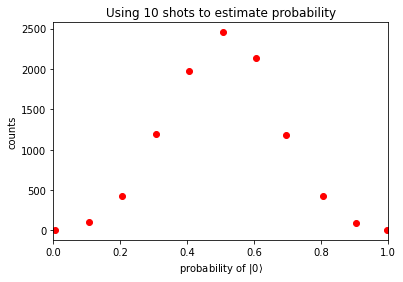

In [8]:
# Set the number of shots
num_shots = 10
# Set the number of times to repeat the experiment
iterations = 10000
# Set the number of bins for the histogram
bin_count = 100

# For each iteration, create job, run the experiment, 
# collect results and calculate probability of |0>
p0_list = []
for _ in range(iterations):

    job = shots_backend.run(circuit, shots=num_shots)

    result = job.result()

    if '0' in result.get_counts().keys():
        p0 = result.get_counts()['0']/num_shots
    else:
        p0 = 1 - result.get_counts()['1']/num_shots

    p0_list.append(p0)

# Calculate a histogram from the results
yhist, xhist = np.histogram(p0_list, bins=bin_count)
# Restrict horizontal axis to 0-1
x_01 = np.array([xhist[n] + (xhist[n + 1] - xhist[n])/2 for n in range(len(xhist)-1)])

# Find x-points for which the histogram has more than zero counts
xh = np.where(yhist > 0)[0]
# Get the y-points of the corresponding x ones
yh = yhist[xh]
# Get the x-points
x_01_h = x_01[xh]

# Plot
plt.scatter(x_01_h, yh, color = 'red')
plt.title(f"Using {num_shots} shots to estimate probability")
plt.xlim((0, 1))
plt.xlabel(r'probability of $\vert 0 \rangle$')
plt.ylabel('counts')
plt.show()

We can fit a Gaussian to the histogram of the counts to estimate the mean and the variance of the data. Use scipy's [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function for the purpose. `curve_fit` will take the function for fitting, the x and y points to fit and a list of the initial guessed values for the fit. It will then return the estimate and the covariance matrix of the parameters `mean` and `sigma` of the `gaussian(...)` function which best fit the data. For grading purposes, append the estimated mean and the estimated standard deviation (in this order) to the `mu_sigma` list which will be submitted.

[100.70330979   0.50406651   0.16018455]
The mean is  0.5040665125021484
The standard deviation is  0.16018454621672984


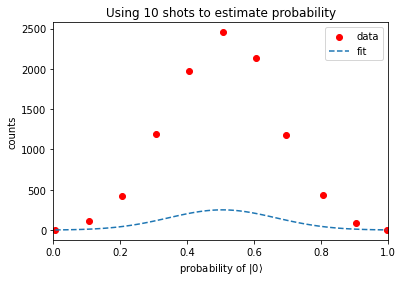

In [9]:
# Define a Gaussian function for the fit
def gaussian(x, a, mean, sigma):
    return a * (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-((x - mean)**2 / (2 * sigma**2)))

# Set initial estimates for the fit: the maximum height of the histogram, the theoretical
# average and the theoretical standard deviation
height_estimate = np.max(yh)
mu_estimate = 0.5
sigma_estimate = np.sqrt(mu_estimate*(1-mu_estimate)/num_shots)

# Define list to store the estimated values of the average (mu_sigma[0]) and standard deviation (mu_sigma[1])
mu_sigma = []

# Use the curve_fit function to fit the experimental data using the definition of the Gaussian function
# which will return the estimate of the parameters.
###INSERT CODE BELOW THIS LINE

popt, pcov = curve_fit(gaussian, xhist[0: len(yhist)], yhist[0: len(yhist)])
print(popt)
mu_sigma.append(popt[1])
mu_sigma.append(popt[2])

###DO NOT EDIT BELOW THIS LINE   

print("The mean is ", mu_sigma[0])
print("The standard deviation is ", mu_sigma[1])

# Plot experimental data and the fit
plt.scatter(x_01_h, yh, label = 'data', color = 'red')
plt.plot(x_01, gaussian(x_01, *popt), label = 'fit', linestyle = '--')
plt.title(f"Using {num_shots} shots to estimate probability")
plt.xlim((0, 1))
plt.xlabel(r'probability of $\vert 0 \rangle$')
plt.ylabel('counts')
plt.legend()
plt.show()

In [10]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex4

grade_lab3_ex4(mu_sigma)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 5) Check the standard deviation for different number of shots
By increasing the number of shots, which is the number of samples in the population, we can improve the estimate of the sample mean and its variance

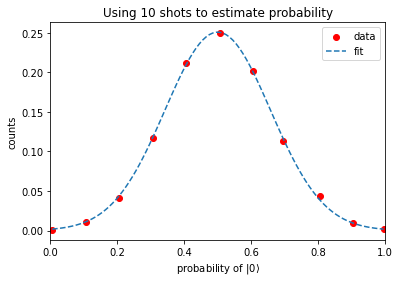

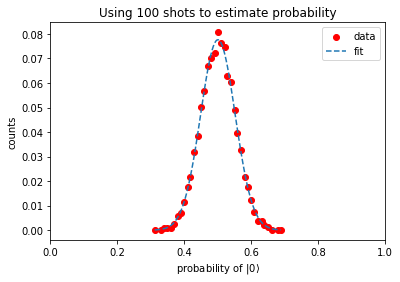

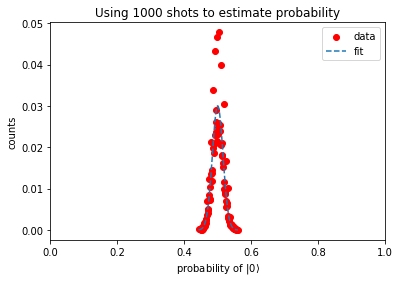

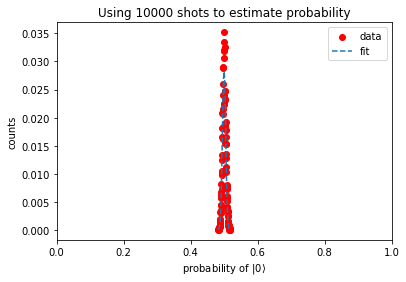

In [11]:
# Set different number of shots
num_shots_list = [10, 100, 1000,10000]
# Set the number of times to repeat the experiment
iterations = 10000
# Set the number of bins for the histogram
bin_count = 100

# Repeat the protocol above for different number of shots to see how the parameters of the
# estimated Gaussian change with the number of shots
popt_list = []
gaussian_curve_list, x_01_list = [], []
for num_shots in num_shots_list:

    p0_list = []
    for _ in range(iterations):

        job = shots_backend.run(circuit, shots=num_shots)

        result = job.result()

        if '0' in result.get_counts().keys():
            p0 = result.get_counts()['0']/num_shots
        else:
            p0 = 1 - result.get_counts()['1']/num_shots

        p0_list.append(p0)



    yhist, xhist = np.histogram(p0_list, bins=bin_count)
    norm_y = np.sum(yhist)
    yhist = yhist/iterations
    x_01 = np.array([xhist[n] + (xhist[n + 1] - xhist[n])/2 for n in range(len(xhist)-1)])


    xh = np.where(yhist > 0)[0]
    yh = yhist[xh]
    x_01_h = x_01[xh]

    height_estimate = np.max(yh)
    mu_estimate = p0
    sigma_estimate = np.sqrt(mu_estimate*(1-mu_estimate)/num_shots)


    popt, pcov = curve_fit(gaussian, x_01_h, yh, [height_estimate, mu_estimate, sigma_estimate])

    gaussian_curve = gaussian(x_01, *popt)
    gaussian_curve_list.append(gaussian_curve)
    x_01_list.append(x_01)
    popt_list.append(popt)


    plt.scatter(x_01_h, yh, label = 'data', color = 'red')
    plt.plot(x_01, gaussian_curve, label = 'fit', linestyle = '--')
    plt.title(f"Using {num_shots} shots to estimate probability")
    plt.xlim((0, 1))
    plt.xlabel(r'probability of $\vert 0 \rangle$')
    plt.ylabel('counts')
    plt.legend()
    plt.show()

Extract the values from the fit that correspond to the estimate of the standard deviation of the Gaussian distribution and check the validity of the formula $\sigma = \sqrt{\frac{p_0 (1 - p_0)}{N}}$.

In [12]:
# Define list which will contain the experimental standard deviations 
sigma_exp_list = []

# Append the standard deviations from the experiments with different number of shots to sigma_exp_list
###INSERT CODE BELOW THIS LINE
for i in range(len(num_shots_list)):
    sigma_exp_list.append(popt_list[i][2])

###DO NOT EDIT BELOW THIS LINE   


# Define theoretical sigma
p=0.5
sigma_th_list = [np.sqrt(p*(1-p)/num_shots) for num_shots in num_shots_list]
print(sigma_th_list)

for sigma_exp, sigma_th in zip(sigma_exp_list, sigma_th_list):
    print(f"The variance from experiment is {sigma_exp} while the theoretical one is {sigma_th}")

[0.15811388300841897, 0.05, 0.015811388300841896, 0.005]
The variance from experiment is 0.15772854881825032 while the theoretical one is 0.15811388300841897
The variance from experiment is 0.0516339988079893 while the theoretical one is 0.05
The variance from experiment is 0.015834356381942638 while the theoretical one is 0.015811388300841896
The variance from experiment is 0.004987503901242117 while the theoretical one is 0.005


In [13]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex5

grade_lab3_ex5(sigma_exp_list)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## III.2: Measurement Noise
Let's now consider the case where the measurement outcomes themselves are affected by noise. This can be thought of as mis-classification events. For example, we'll want to find out the probabilities of preparing the qubit in a certain state but then finding it in another one when measured. This type of error is often reffered to as State Preparation And Measurement (SPAM) error.

#### Create measurement noise model

In [14]:
# Set number of shots
num_shots_measurement = 10000

# Create an empty noise model
readout_noise_model = NoiseModel()

# Measurement miss-assignement probabilities
p0given1 = 0.3 # Probability of measuuring |0> given the state is |1>
p1given0 = 0.05 # Probability of measuring |1> given the state is |0>
readout_error = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]]) # Define readout error
readout_noise_model.add_readout_error(readout_error, [0]) # Add error to noise model


#### 1) First, prepare the qubit in the $\vert 0 \rangle$ state and determine the probability of observing the qubit in the $\vert 0 \rangle$ or $\vert 1 \rangle$

In [15]:
# Calculate probability of seeing |0> given that |0> is prepared
circuit_0 = qiskit.QuantumCircuit(quantum_register, classical_register)

# Add measurement
###INSERT CODE BELOW THIS LINE
circuit_0.measure(0,0)

###DO NOT EDIT BELOW THIS LINE


In [16]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex6

grade_lab3_ex6(circuit_0)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [17]:
# Run the experiment
job = shots_backend.run(circuit_0, shots=num_shots_measurement, noise_model=readout_noise_model)
# Retrieve results
result = job.result()

# Calculate probability of |0>
if '0' in result.get_counts().keys():
    p0_0 = result.get_counts()['0']/num_shots_measurement
else:
    p0_0 = 1 - result.get_counts()['1']/num_shots_measurement

p1_0 = 1 - p0_0

print('Probability of measuring |0> when |0> is prepared:', p0_0)
print('Probability of measuring |1> when |0> is prepared:', p1_0)

Probability of measuring |0> when |0> is prepared: 0.9509
Probability of measuring |1> when |0> is prepared: 0.04910000000000003


### 2) Then prepare the qubit in the $\vert 1 \rangle$ state and determine the probability of observing the qubit in the $\vert 1 \rangle$ or $\vert 0 \rangle$

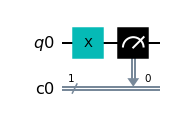

In [18]:
# Calculate probability of seeing |1> given that |1> is prepared
circuit_1 = qiskit.QuantumCircuit(quantum_register, classical_register)

# Add X gate and measurement
###INSERT CODE BELOW THIS LINE

circuit_1.x(0)
circuit_1.measure(0,0)

circuit_1.draw()
###DO NOT EDIT BELOW THIS LINE





In [19]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex7

grade_lab3_ex7(circuit_1)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [20]:
# Run the experiment
job = shots_backend.run(circuit_1, shots=num_shots_measurement, noise_model=readout_noise_model)
# Retrieve results
result = job.result()

# Calculate probability of |0>
if '0' in result.get_counts().keys():
    p1_1 = 1 - result.get_counts()['0']/num_shots_measurement
else:
    p1_1 = result.get_counts()['1']/num_shots_measurement

p0_1 = 1 - p1_1


print('Probability of measuring |0> when |1> is prepared:', p0_1)
print('Probability of measuring |1> when |1> is prepared:', p1_1)


Probability of measuring |0> when |1> is prepared: 0.2986
Probability of measuring |1> when |1> is prepared: 0.7014


### 3) Next build the confusion matrix from the measurements
The confusion matrix represents the linear transformation which takes the noiseless probabilities and adds the effect of mis-classification returning noisy probabilities


$$p_{noisy} = A \times p_{ideal}$$

where

$$ A = \begin{pmatrix} p(0|0) & p(0|1)\\
p(1|0) & p(1|1)\end{pmatrix}  $$

In [21]:
# Define the confusion matrix from the probabilities found above
###INSERT CODE BELOW THIS LINE

confusion_matrix = np.array([[p0_0, p0_1], [p1_0, p1_1]])

###DO NOT EDIT BELOW THIS LINE


print("Confusion matrix:")
print(confusion_matrix)



Confusion matrix:
[[0.9509 0.2986]
 [0.0491 0.7014]]


In [22]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex8

# The grader expects a np.array object (not list)
grade_lab3_ex8(confusion_matrix)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


#### 4) Finally, use confusion matrix to mitigate results of noisy experiment
Let's run a noisy experiment

In [23]:
# Run experiments
job = shots_backend.run(circuit, shots=num_shots_measurement, noise_model=readout_noise_model)
# Extract results
result = job.result()

# Calculate probability of |0>
if '0' in result.get_counts().keys():
    p0_noisy = result.get_counts()['0']/num_shots_measurement
    p1_noisy = 1 - p0_noisy
else:
    p0_noisy = 1 - result.get_counts()['1']/num_shots_measurement
    p1_noisy = 1 - p0_noisy

p_vector_noisy = np.array([p0_noisy, p1_noisy])
print("Noisy probability of |0>: ", p0_noisy)
print("Noisy probability of |1>: ", p1_noisy)


Noisy probability of |0>:  0.6314
Noisy probability of |1>:  0.36860000000000004


And now we can mitigate the results using the estimated confusion matrix. First find the inverse of the confusion matrixa and then multiply it by the noisy probabilities

$$p_{ideal} = A^{-1} \times p_{noisy}$$

The resulting vector must be clipped and normalized to make sure that it represent valid probabilities

In [24]:
# Invert the confusion matrix
inverse_confusion_matrix = np.linalg.inv(confusion_matrix)

# Mitigate the counts using the inverse of the confusion matrix
###INSERT CODE BELOW THIS LINE
p_vector_mitigated = inverse_confusion_matrix @ p_vector_noisy
###DO NOT EDIT BELOW THIS LINE


print("Mitigated probability of |0>: ", p_vector_mitigated[0])
print("Mitigated probability of |1>: ", p_vector_mitigated[1])


Mitigated probability of |0>:  0.510194695692166
Mitigated probability of |1>:  0.48980530430783387


In [25]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex9

# The grader expects a np.array object (not list)
grade_lab3_ex9(p_vector_mitigated)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


And compare it to the results of an ideal experiment

In [26]:
# Run ideal experiments
job = shots_backend.run(circuit, shots=num_shots_measurement)
# Extract results
result = job.result()

# Calculate probability of |0>
if '0' in result.get_counts().keys():
    p0_ideal = result.get_counts()['0']/num_shots_measurement
    p1_ideal = 1 - p0_ideal
else:
    p0_ideal = 1 - result.get_counts()['1']/num_shots_measurement
    p1_ideal = 1 - p0_ideal

print("Ideal probability of |0>: ", p0_ideal)
print("Ideal probability of |1>: ", p1_ideal)


Ideal probability of |0>:  0.5036
Ideal probability of |1>:  0.49639999999999995


## II.3: Coherent Noise
Coherent noise may creep in our quantum computers as a result of miscalibrations. For example, a rotation of an angle $\theta$ actually implement a $\theta + \epsilon$ rotation. Below we'll consider the case where the gate that implements a rotation around the $x$ axis RX($\theta$) gate is affected by an over rotation of $\epsilon$

In [27]:
# Set number of shots
num_shots_coherent = 100

# Create an empty noise model
rx_overrotation_noise_model = NoiseModel()

# Construct a 1 qubit over-rotation of the RX gate
epsilon = np.pi/5 # over rotation amount
epsilon_rotation = RXGate(epsilon).to_matrix() # get matrix representation

# Create coherent error
over_rotation = coherent_unitary_error(epsilon_rotation)

# Add error to error model
rx_overrotation_noise_model.add_quantum_error(over_rotation, ['rx'], qubits = [0])

### 1) Build a circuit with an RX($\theta$) gate where $\theta = \pi$
Don't forget to add measurement in the end.

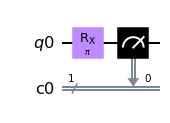

In [28]:
# Set value of rotation
theta = np.pi
# Instantiate a quantum circuit
circuit = qiskit.QuantumCircuit(quantum_register, classical_register)

# Add a parametrized RX rotation and bind the value of the parameter. (By default, parameter binding is not an in-place operation)
# Then measure the qubit and calculate probability of seeing |0> after rx(np.pi) 
###INSERT CODE BELOW THIS LINE
circuit.rx(theta, 0)
circuit.measure(0, 0)
circuit.draw()
###DO NOT EDIT BELOW THIS LINE



In [29]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex10

grade_lab3_ex10(circuit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Given the coherent noise present in the $RX(\theta)$ gate, a $\pi$ rotation around the $x$ axis won't take the $\vert 0 \rangle$ state to the $\vert 1 \rangle$ state exactly

In [30]:
# Run experiments
job = shots_backend.run(circuit, shots=num_shots_coherent, noise_model=rx_overrotation_noise_model)
# Extract results
result = job.result()

# Calculate the probability of |0>
if '0' in result.get_counts().keys():
    p0 = result.get_counts()['0']/num_shots_coherent
else:
    p0 = 1 - result.get_counts()['1']/num_shots_coherent

print("Noisy probability of |0> after coherent error in idling: ", p0)
print("Noisy probability of |1> after coherent error in idling: ", 1-p0)

Noisy probability of |0> after coherent error in idling:  0.08
Noisy probability of |1> after coherent error in idling:  0.92


## l.4: Incoherent Noise
We can explore the effects of incoherent noise using Qiskit as well


### 1) Construct a depolarizing noise model
Now that you've seen how to create noise model for the measurement and coherent error, can you build one for a 5% depolarizing error on the idle (`id`) gate for qubit 0?

In [31]:
# Define number of shots
num_shots_inchoherent = 10000

# Create an empty noise model
depolarizing_noise_model = NoiseModel()

# Define a depolarizing error on the identity gate for qubit zero and add it to the noise model
###INSERT CODE BELOW THIS LINE
import qiskit.providers.aer.noise as noise

err = noise.depolarizing_error(0.05, 1)
depolarizing_noise_model.add_quantum_error(err, ['id'], [0])

###DO NOT EDIT BELOW THIS LINE



In [32]:
from qc_grader.challenges.qgss_2022 import grade_lab3_ex11

grade_lab3_ex11(depolarizing_noise_model)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Let's use the noise model to see the effect of depolarizing error when the qubit is idling

In [33]:
# Create a circuit with an idle instruction
circuit_idle = qiskit.QuantumCircuit(quantum_register, classical_register)
circuit_idle.id(0)
circuit_idle.measure(0,0)

# Run experiments
job = shots_backend.run(circuit_idle, shots=num_shots_inchoherent, noise_model=depolarizing_noise_model)
# Extract results
result = job.result()

# Calculate probability of seeing |0> after idle time
if '0' in result.get_counts().keys():
    p0 = result.get_counts()['0']/num_shots_inchoherent
else:
    p0 = 1 - result.get_counts()['1']/num_shots_inchoherent

print("Noisy probability of |0> after coherent error in idling: ", p0)
print("Noisy probability of |1> after coherent error in idling: ", 1-p0)


Noisy probability of |0> after coherent error in idling:  0.9754
Noisy probability of |1> after coherent error in idling:  0.024599999999999955
